# Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import time
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, f1_score

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# 1. Data Preprocessing

Memuat dan memproses dataset NusaX-Sentiment untuk analisis sentimen dalam Bahasa Indonesia.

Dataset sizes: Train=500, Valid=100, Test=400
Kelas dalam dataset: ['negative', 'neutral', 'positive']
Distribusi label train: [192 119 189]
Distribusi label valid: [38 24 38]
Distribusi label test: [153  96 151]


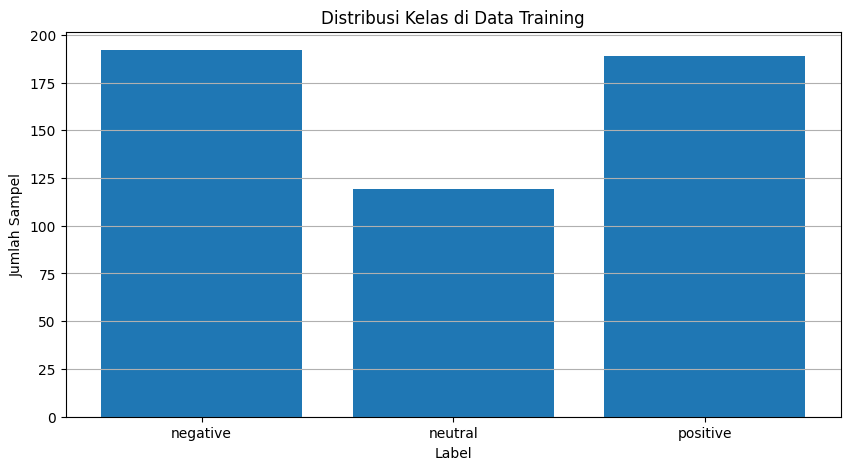

Vocabulary size: 2836

Contoh data:
Text: Nikmati cicilan 0% hingga 12 bulan untuk pemesanan tiket pesawat air asia dengan kartu kredit bni!... | Label: neutral
Text: Kue-kue yang disajikan bikin saya bernostalgia. Semuanya tipikal kue zaman dulu, baik dari penampila... | Label: positive
Text: Ibu pernah bekerja di grab indonesia... | Label: neutral


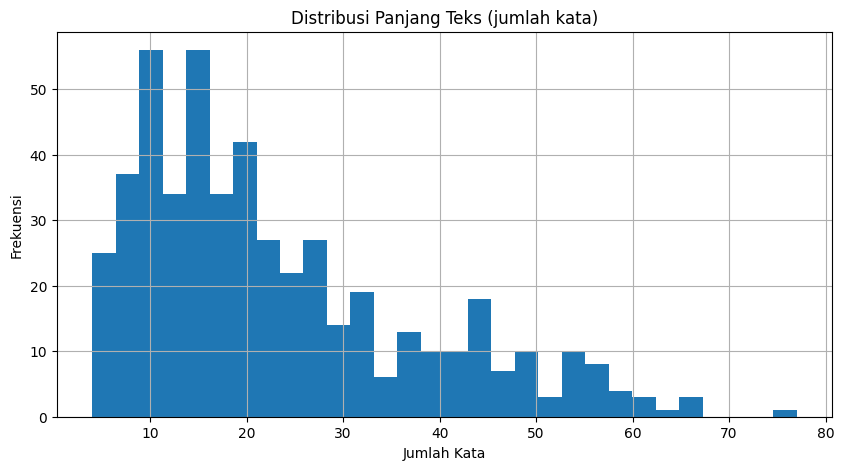

Panjang rata-rata (kata): 23.1
Panjang median (kata): 19.0
Panjang maksimum (kata): 77


In [2]:
from data_preprocessing import load_data, create_text_vectorizer, compute_f1_score

# Muat data
(train_texts, train_labels), (valid_texts, valid_labels), (test_texts, test_labels), label_mapping, num_classes = load_data()

# Tampilkan informasi data
print(f"Dataset sizes: Train={len(train_texts)}, Valid={len(valid_texts)}, Test={len(test_texts)}")
print(f"Kelas dalam dataset: {list(label_mapping.keys())}")
print(f"Distribusi label train: {np.bincount(train_labels)}")
print(f"Distribusi label valid: {np.bincount(valid_labels)}")
print(f"Distribusi label test: {np.bincount(test_labels)}")

# Visualisasi distribusi kelas
plt.figure(figsize=(10, 5))
class_counts = np.bincount(train_labels)
plt.bar(list(label_mapping.keys()), class_counts)
plt.title('Distribusi Kelas di Data Training')
plt.xlabel('Label')
plt.ylabel('Jumlah Sampel')
plt.grid(axis='y')
plt.show()

# Buat text vectorizer
vectorizer, vocab, vocab_size = create_text_vectorizer(train_texts)
print(f"Vocabulary size: {vocab_size}")

# Tampilkan beberapa contoh teks dan label
print("\nContoh data:")
for i in range(3):
    sentiment = list(label_mapping.keys())[train_labels[i]]
    print(f"Text: {train_texts[i][:100]}... | Label: {sentiment}")
    
# Visualisasikan panjang teks
text_lengths = [len(text.split()) for text in train_texts]
plt.figure(figsize=(10, 5))
plt.hist(text_lengths, bins=30)
plt.title('Distribusi Panjang Teks (jumlah kata)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

print(f"Panjang rata-rata (kata): {np.mean(text_lengths):.1f}")
print(f"Panjang median (kata): {np.median(text_lengths):.1f}")
print(f"Panjang maksimum (kata): {np.max(text_lengths)}")

# 2 Model SimpleRNN Dasar

Di bagian ini kita akan membuat dan melatih model SimpleRNN dasar untuk klasifikasi sentimen.

In [3]:
from model import create_rnn_model
import config

# Cek parameter default dari config
print("Parameter model dari config.py:")
print(f"- Embedding dimension: {config.EMBEDDING_DIM}")
print(f"- RNN units: {config.RNN_UNITS}")
print(f"- Number of RNN layers: {config.NUM_RNN_LAYERS}")
print(f"- Bidirectional: {config.BIDIRECTIONAL}")
print(f"- Dropout rate: {config.DROPOUT_RATE}")
print(f"- Batch size: {config.BATCH_SIZE}")
print(f"- Max epochs: {config.EPOCHS}")

Parameter model dari config.py:
- Embedding dimension: 96
- RNN units: 48
- Number of RNN layers: 1
- Bidirectional: True
- Dropout rate: 0.3
- Batch size: 24
- Max epochs: 30



Pelatihan model baseline...

--- Training Model: baseline_model ---
Config: Layers=1, Units=48, Bidirectional=True, Dropout=0.3, L2=0.01
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 96)         │       272,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 96)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ (None, 96)             │        13,920 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,467 (1.09 MB)

 Trainable params: 286,467 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3438 - loss: 5.2342
Epoch 1: val_loss improved from inf to 4.08557, saving model to checkpoints/baseline_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3448 - loss: 5.2174 - val_accuracy: 0.5300 - val_loss: 4.0856 - learning_rate: 0.0010
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4081 - loss: 3.9477
Epoch 2: val_loss improved from 4.08557 to 3.49381, saving model to checkpoints/baseline_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4081 - loss: 3.9401 - val_accuracy: 0.4800 - val_loss: 3.4938 - learning_rate: 0.0010
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4668 - loss: 3.3916
Epoch 3: val_loss improved from 3.49381 to 3.17365, saving model to checkpoints/baseline_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4670 - loss: 3.3870 - val_accuracy: 0.5400 - val_loss: 3.1736 - learning

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Vectorizer disimpan di: models/baseline_model_vectorizer.keras


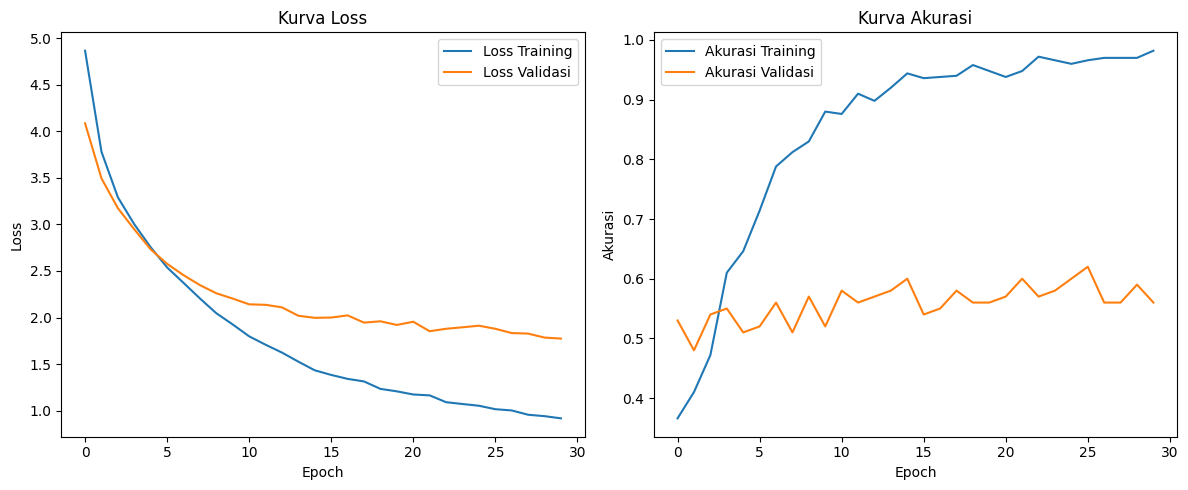


Metrik evaluasi model baseline:
Accuracy: 0.5975
F1 Score: 0.5703
Loss: 1.7237


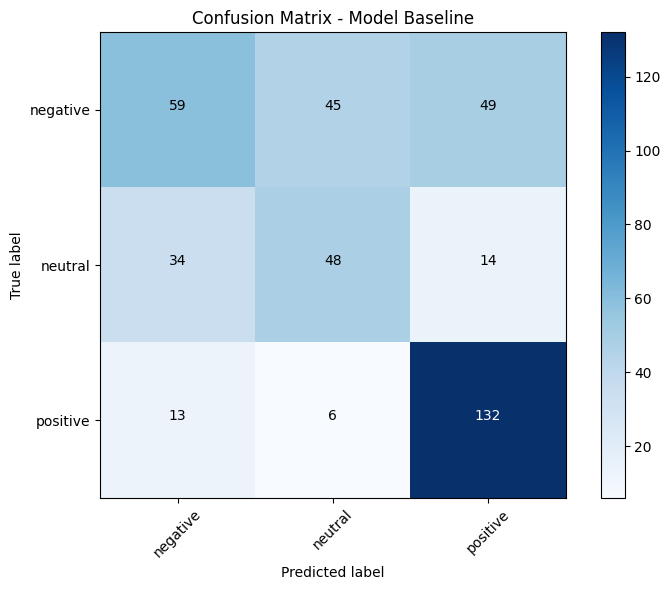

In [4]:
# Impor fungsi training dan evaluasi dari train.py
from train import train_and_evaluate_model, plot_training_history

# Buat folder untuk menyimpan hasil
os.makedirs("models", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Latih model baseline
print("\nPelatihan model baseline...")
model_baseline, history_baseline, preds_baseline, labels_baseline, vectorizer_baseline, metrics_baseline = train_and_evaluate_model(
    model_name="baseline_model"
)

# Plot kurva training
plot_training_history(history_baseline, "baseline_model")

# Tampilkan metrik evaluasi
print("\nMetrik evaluasi model baseline:")
print(f"Accuracy: {metrics_baseline['test_accuracy']:.4f}")
print(f"F1 Score: {metrics_baseline['test_f1']:.4f}")
print(f"Loss: {metrics_baseline['test_loss']:.4f}")

# Visualisasi prediksi vs label sebenarnya
pred_classes = np.argmax(preds_baseline, axis=1)
cm = confusion_matrix(labels_baseline, pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Model Baseline')
plt.colorbar()

class_names = list(label_mapping.keys())
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

# Tambahkan teks nilai ke confusion matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

# 3. Eksperimen Variasi Parameter

Di bagian ini kita melakukan eksperimen untuk menguji pengaruh:
1. Jumlah layer RNN
2. Jumlah unit RNN per layer
3. Arah RNN (unidirectional vs bidirectional)

In [5]:
RESULTS_DIR = "experiment_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Definisikan variasi parameter yang akan diuji
RNN_LAYERS_VARIATIONS = [1, 2, 3]  # 3 variasi jumlah layer
RNN_UNITS_VARIATIONS = [24, 48, 96]  # 3 variasi jumlah unit per layer
BIDIRECTIONAL_VARIATIONS = [False, True]  # unidirectional vs bidirectional

## 3.1 Eksperimen Jumlah Layer
3 variasi jumlah layer RNN: 1, 2, dan 3 layer.

In [7]:
def run_layer_count_experiment():
    """Jalankan eksperimen untuk menguji pengaruh jumlah layer RNN"""
    print("\n" + "="*50)
    print("EKSPERIMEN: VARIASI JUMLAH LAYER RNN")
    print("="*50)
    
    results = []
    histories = {}
    
    # Uji untuk setiap jumlah layer
    for num_layers in RNN_LAYERS_VARIATIONS:
        model_name = f"rnn_layers_{num_layers}"
        print(f"\nTesting model dengan {num_layers} layer RNN")
        
        # Latih model dengan variasi ini
        start_time = time.time()
        _, history, preds, labels, _, metrics = train_and_evaluate_model(
            num_rnn_layers=num_layers,
            model_name=model_name
        )
        train_time = time.time() - start_time
        
        # Simpan hasilnya
        results.append({
            'num_layers': num_layers,
            'accuracy': metrics['test_accuracy'],
            'f1_score': metrics['test_f1'],
            'loss': metrics['test_loss'],
            'train_time': train_time
        })
        
        # Simpan history untuk plot
        histories[num_layers] = history
    
    # Konversi ke DataFrame untuk analisis lebih mudah
    results_df = pd.DataFrame(results)
    
    # Simpan hasil ke CSV (tanpa timestamp)
    csv_path = f"{RESULTS_DIR}/layer_count_results.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"Hasil eksperimen jumlah layer disimpan di {csv_path}")
    
    return results_df, histories

# Jalankan eksperimen variasi jumlah layer RNN
layer_results_df, layer_histories = run_layer_count_experiment()


EKSPERIMEN: VARIASI JUMLAH LAYER RNN

Testing model dengan 1 layer RNN

--- Training Model: rnn_layers_1 ---
Config: Layers=1, Units=48, Bidirectional=True, Dropout=0.3, L2=0.01
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 96)         │       272,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 96)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ (None, 96)             │        13,920 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,467 (1.09 MB)

 Trainable params: 286,467 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3307 - loss: 5.2903
Epoch 1: val_loss improved from inf to 4.23524, saving model to checkpoints/rnn_layers_1.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.3312 - loss: 5.2719 - val_accuracy: 0.2600 - val_loss: 4.2352 - learning_rate: 0.0010
Epoch 2/30
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3561 - loss: 4.0471
Epoch 2: val_loss improved from 4.23524 to 3.61063, saving model to checkpoints/rnn_layers_1.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3592 - loss: 4.0248 - val_accuracy: 0.3200 - val_loss: 3.6106 - learning_rate: 0.0010
Epoch 3/30
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3891 - loss: 3.4967
Epoch 3: val_loss improved from 3.61063 to 3.27980, saving model to checkpoints/rnn_layers_1.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3904 - loss: 3.4850 - val_accuracy: 0.4000 - val_loss: 3.2798 - learning_rate:

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 96)         │       272,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 96)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ (None, 80, 96)         │        13,920 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ (None, 80, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_2             │ (None, 96)             │        13,920 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_2 (Dropout)         │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 300,387 (1.15 MB)

 Trainable params: 300,387 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/30
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3631 - loss: 7.5622
Epoch 1: val_loss improved from inf to 6.42109, saving model to checkpoints/rnn_layers_2.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3575 - loss: 7.4903 - val_accuracy: 0.2300 - val_loss: 6.4211 - learning_rate: 0.0010
Epoch 2/30
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3543 - loss: 6.2657
Epoch 2: val_loss improved from 6.42109 to 5.66705, saving model to checkpoints/rnn_layers_2.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3563 - loss: 6.2375 - val_accuracy: 0.3900 - val_loss: 5.6670 - learning_rate: 0.0010
Epoch 3/30
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4102 - loss: 5.5817
Epoch 3: val_loss improved from 5.66705 to 5.21117, saving model to checkpoints/rnn_layers_2.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4087 - loss: 5.5675 - val_accuracy: 0.3100 - val_loss: 5.2112 - learning_rate:

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 96)         │       272,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 96)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ (None, 80, 96)         │        13,920 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ (None, 80, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_2             │ (None, 80, 96)         │        13,920 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_2 (Dropout)         │ (None, 80, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_3             │ (None, 96)             │        13,920 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_3 (Dropout)         │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,307 (1.20 MB)

 Trainable params: 314,307 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3481 - loss: 9.9129
Epoch 1: val_loss improved from inf to 8.84689, saving model to checkpoints/rnn_layers_3.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.3480 - loss: 9.8961 - val_accuracy: 0.3600 - val_loss: 8.8469 - learning_rate: 0.0010
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3758 - loss: 8.6957
Epoch 2: val_loss improved from 8.84689 to 8.21027, saving model to checkpoints/rnn_layers_3.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3749 - loss: 8.6905 - val_accuracy: 0.2600 - val_loss: 8.2103 - learning_rate: 0.0010
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3117 - loss: 8.1885
Epoch 3: val_loss improved from 8.21027 to 7.61597, saving model to checkpoints/rnn_layers_3.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3119 - loss: 8.1811 - val_accuracy: 0.4700 - val_loss: 7.6160 - learning_rate:

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)



Hasil Eksperimen Jumlah Layer:


,num_layers,accuracy,f1_score,loss,train_time
0,1,0.6050,0.593736,1.803163,13.708447
1,2,0.5375,0.514738,2.287036,19.876555
2,3,0.4825,0.473370,2.691531,28.234335


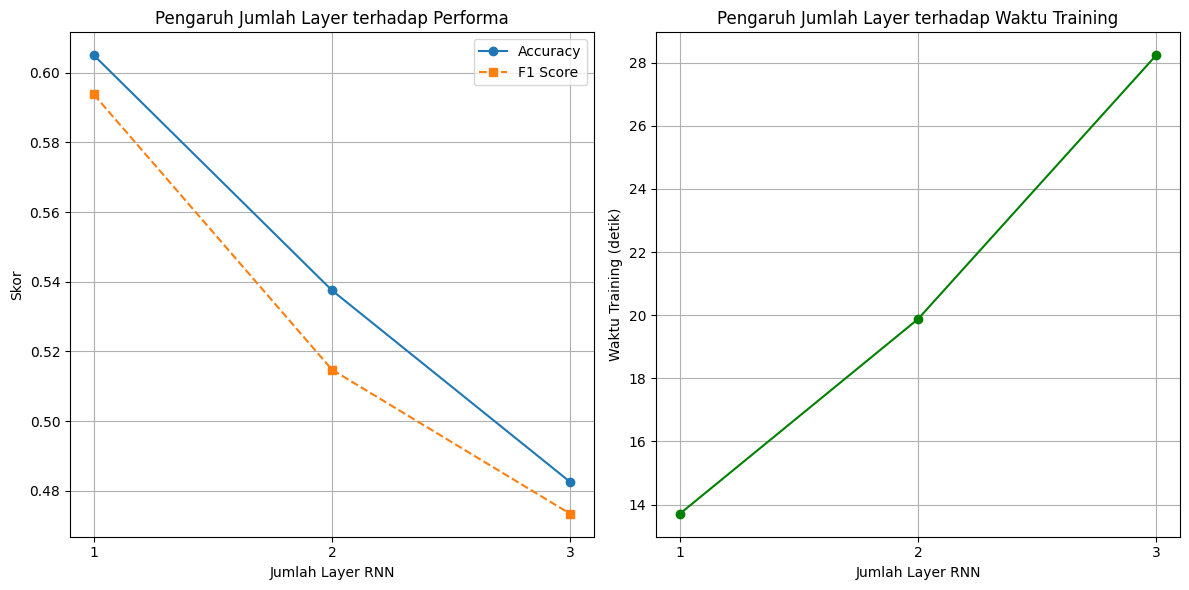

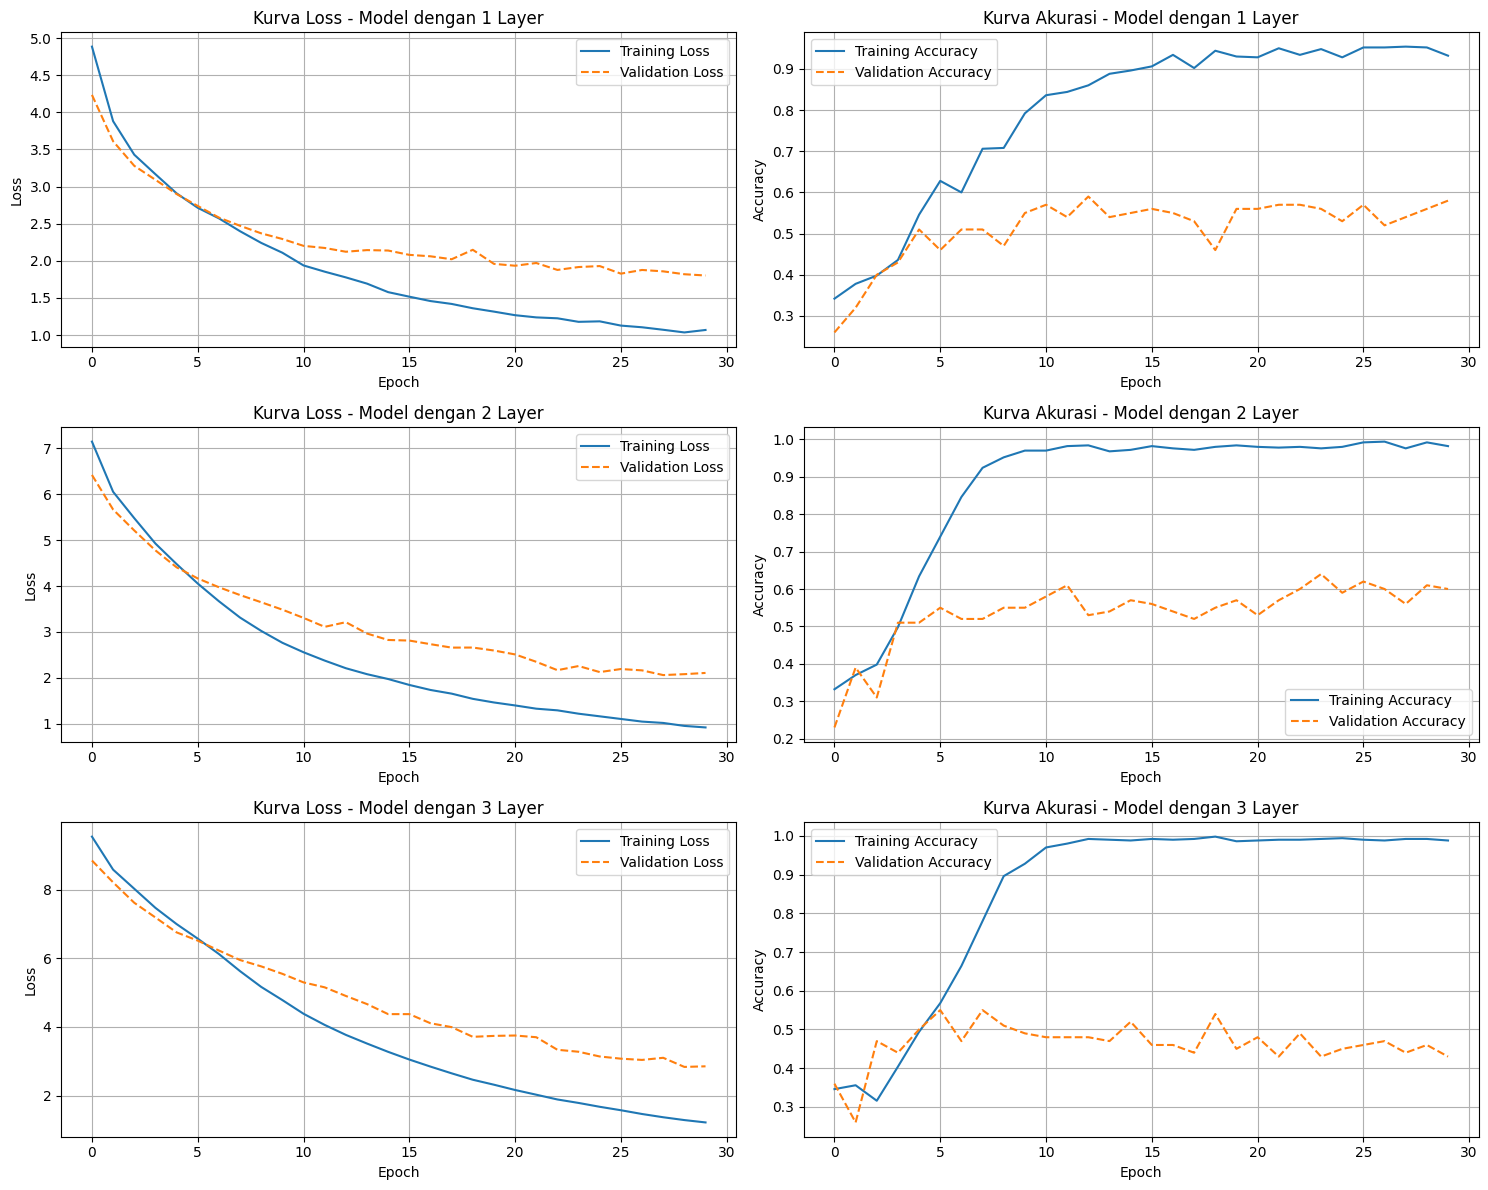

In [8]:
# Tampilkan hasil dalam tabel
print("\nHasil Eksperimen Jumlah Layer:")
display(layer_results_df)

# Visualisasikan pengaruh jumlah layer terhadap performa
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(layer_results_df['num_layers'], layer_results_df['accuracy'], 'o-', label='Accuracy')
plt.plot(layer_results_df['num_layers'], layer_results_df['f1_score'], 's--', label='F1 Score')
plt.xlabel('Jumlah Layer RNN')
plt.ylabel('Skor')
plt.title('Pengaruh Jumlah Layer terhadap Performa')
plt.xticks(layer_results_df['num_layers'])
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(layer_results_df['num_layers'], layer_results_df['train_time'], 'o-', color='green')
plt.xlabel('Jumlah Layer RNN')
plt.ylabel('Waktu Training (detik)')
plt.title('Pengaruh Jumlah Layer terhadap Waktu Training')
plt.xticks(layer_results_df['num_layers'])
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot kurva learning untuk setiap variasi jumlah layer (satu model per plot)
plt.figure(figsize=(15, 4 * len(RNN_LAYERS_VARIATIONS)))

for i, layers in enumerate(RNN_LAYERS_VARIATIONS):
    # Plot Loss
    plt.subplot(len(RNN_LAYERS_VARIATIONS), 2, 2*i + 1)
    plt.plot(layer_histories[layers].history['loss'], label='Training Loss')
    plt.plot(layer_histories[layers].history['val_loss'], '--', label='Validation Loss')
    plt.title(f'Kurva Loss - Model dengan {layers} Layer')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(len(RNN_LAYERS_VARIATIONS), 2, 2*i + 2)
    plt.plot(layer_histories[layers].history['accuracy'], label='Training Accuracy')
    plt.plot(layer_histories[layers].history['val_accuracy'], '--', label='Validation Accuracy')
    plt.title(f'Kurva Akurasi - Model dengan {layers} Layer')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


## 3.2 Eksperimen Jumlah Unit RNN
3 variasi jumlah unit per layer: 24, 48, dan 96 unit

In [15]:
def run_unit_count_experiment():
    """Jalankan eksperimen untuk menguji pengaruh jumlah unit RNN"""
    print("\n" + "="*50)
    print("EKSPERIMEN: VARIASI JUMLAH UNIT RNN")
    print("="*50)
    
    results = []
    histories = {}
    
    # Uji untuk setiap jumlah unit
    for num_units in RNN_UNITS_VARIATIONS:
        model_name = f"rnn_units_{num_units}"
        print(f"\nTesting model dengan {num_units} unit RNN")
        
        # Latih model dengan variasi ini
        start_time = time.time()
        _, history, preds, labels, _, metrics = train_and_evaluate_model(
            rnn_units=num_units,
            model_name=model_name
        )
        train_time = time.time() - start_time
        
        # Simpan hasilnya
        results.append({
            'num_units': num_units,
            'accuracy': metrics['test_accuracy'],
            'f1_score': metrics['test_f1'],
            'loss': metrics['test_loss'],
            'train_time': train_time
        })
        
        # Simpan history untuk plot
        histories[num_units] = history
    
    # Konversi ke DataFrame
    results_df = pd.DataFrame(results)
    
    # Simpan hasil ke CSV
    csv_path = f"{RESULTS_DIR}/unit_count_results.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"Hasil eksperimen jumlah unit disimpan di {csv_path}")
    
    return results_df, histories

# Jalankan eksperimen variasi jumlah unit RNN
unit_results_df, unit_histories = run_unit_count_experiment()


EKSPERIMEN: VARIASI JUMLAH UNIT RNN

Testing model dengan 24 unit RNN

--- Training Model: rnn_units_24 ---
Config: Layers=1, Units=24, Bidirectional=True, Dropout=0.3, L2=0.01
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 96)         │       272,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 96)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ (None, 48)             │         5,808 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,211 (1.06 MB)

 Trainable params: 278,211 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/30
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3228 - loss: 4.3101
Epoch 1: val_loss improved from inf to 3.37207, saving model to checkpoints/rnn_units_24.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3234 - loss: 4.2772 - val_accuracy: 0.3100 - val_loss: 3.3721 - learning_rate: 0.0010
Epoch 2/30
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3791 - loss: 3.2140
Epoch 2: val_loss improved from 3.37207 to 2.86769, saving model to checkpoints/rnn_units_24.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3788 - loss: 3.1954 - val_accuracy: 0.4000 - val_loss: 2.8677 - learning_rate: 0.0010
Epoch 3/30
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4113 - loss: 2.7923
Epoch 3: val_loss improved from 2.86769 to 2.66281, saving model to checkpoints/rnn_units_24.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4137 - loss: 2.7841 - val_accuracy: 0.3700 - val_loss: 2.6628 - learning_rate:

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 96)         │       272,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 96)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ (None, 96)             │        13,920 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,467 (1.09 MB)

 Trainable params: 286,467 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3386 - loss: 5.2457
Epoch 1: val_loss improved from inf to 4.26268, saving model to checkpoints/rnn_units_48.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3390 - loss: 5.2298 - val_accuracy: 0.3500 - val_loss: 4.2627 - learning_rate: 0.0010
Epoch 2/30
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3938 - loss: 4.1768
Epoch 2: val_loss improved from 4.26268 to 3.74484, saving model to checkpoints/rnn_units_48.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3926 - loss: 4.1532 - val_accuracy: 0.3700 - val_loss: 3.7448 - learning_rate: 0.0010
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4399 - loss: 3.6490
Epoch 3: val_loss improved from 3.74484 to 3.45893, saving model to checkpoints/rnn_units_48.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4387 - loss: 3.6460 - val_accuracy: 0.3500 - val_loss: 3.4589 - learning_rate:

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 96)         │       272,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 96)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ (None, 192)            │        37,056 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           579 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,891 (1.18 MB)

 Trainable params: 309,891 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/30
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3681 - loss: 6.8521
Epoch 1: val_loss improved from inf to 5.54248, saving model to checkpoints/rnn_units_96.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.3630 - loss: 6.7693 - val_accuracy: 0.3900 - val_loss: 5.5425 - learning_rate: 0.0010
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3610 - loss: 5.3741
Epoch 2: val_loss improved from 5.54248 to 4.74023, saving model to checkpoints/rnn_units_96.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3617 - loss: 5.3639 - val_accuracy: 0.4100 - val_loss: 4.7402 - learning_rate: 0.0010
Epoch 3/30
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4043 - loss: 4.5875
Epoch 3: val_loss improved from 4.74023 to 4.26443, saving model to checkpoints/rnn_units_96.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4041 - loss: 4.5777 - val_accuracy: 0.4000 - val_loss: 4.2644 - learning_rate:

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)



Hasil Eksperimen Jumlah Unit RNN:


,num_units,accuracy,f1_score,loss,train_time
0,24,0.3825,0.358394,2.050279,13.873381
1,48,0.5750,0.546508,1.787028,14.152757
2,96,0.5925,0.560144,1.880376,14.506904


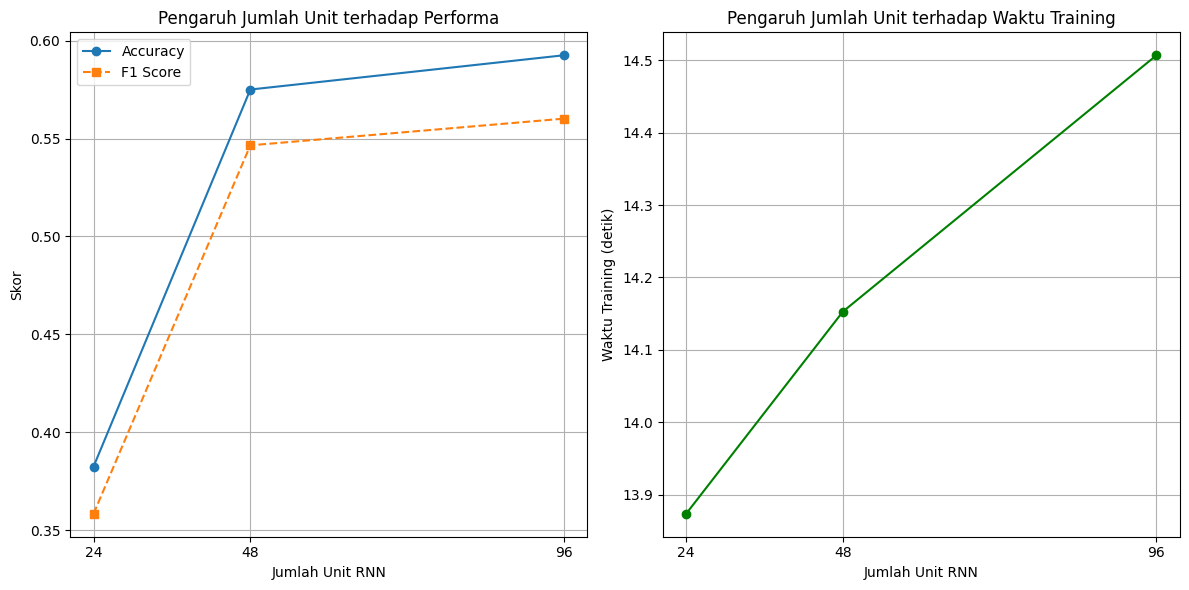

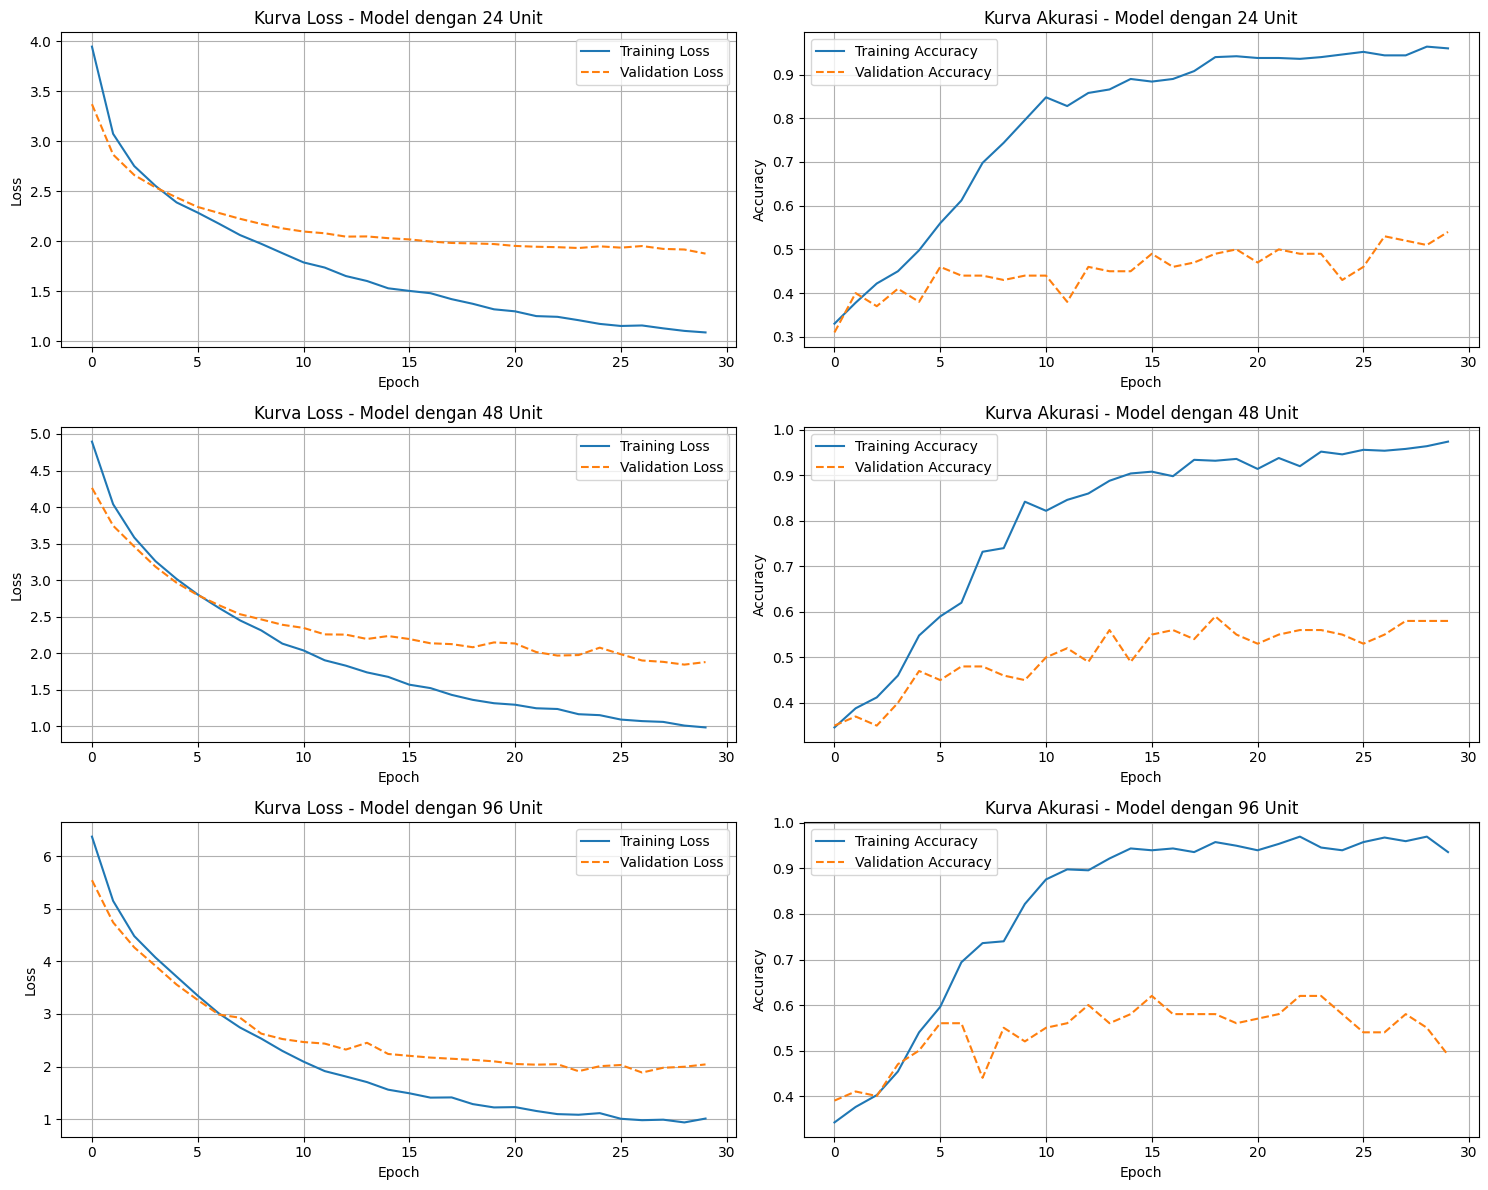

In [16]:
# Tampilkan hasil dalam tabel
print("\nHasil Eksperimen Jumlah Unit RNN:")
display(unit_results_df)

# Visualisasikan pengaruh jumlah unit
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(unit_results_df['num_units'], unit_results_df['accuracy'], 'o-', label='Accuracy')
plt.plot(unit_results_df['num_units'], unit_results_df['f1_score'], 's--', label='F1 Score')
plt.xlabel('Jumlah Unit RNN')
plt.ylabel('Skor')
plt.title('Pengaruh Jumlah Unit terhadap Performa')
plt.xticks(unit_results_df['num_units'])
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(unit_results_df['num_units'], unit_results_df['train_time'], 'o-', color='green')
plt.xlabel('Jumlah Unit RNN')
plt.ylabel('Waktu Training (detik)')
plt.title('Pengaruh Jumlah Unit terhadap Waktu Training')
plt.xticks(unit_results_df['num_units'])
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot kurva learning untuk setiap variasi jumlah unit
plt.figure(figsize=(15, 4 * len(RNN_UNITS_VARIATIONS)))

for i, units in enumerate(RNN_UNITS_VARIATIONS):
    # Plot Loss
    plt.subplot(len(RNN_UNITS_VARIATIONS), 2, 2*i + 1)
    plt.plot(unit_histories[units].history['loss'], label='Training Loss')
    plt.plot(unit_histories[units].history['val_loss'], '--', label='Validation Loss')
    plt.title(f'Kurva Loss - Model dengan {units} Unit')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(len(RNN_UNITS_VARIATIONS), 2, 2*i + 2)
    plt.plot(unit_histories[units].history['accuracy'], label='Training Accuracy')
    plt.plot(unit_histories[units].history['val_accuracy'], '--', label='Validation Accuracy')
    plt.title(f'Kurva Akurasi - Model dengan {units} Unit')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


## 3.3 Eksperimen RNN Bidirectional vs Unidirectional
2 variasi arah RNN: unidirectional dan bidirectional

In [17]:
def run_bidirectional_experiment():
    """Jalankan eksperimen untuk membandingkan RNN satu arah vs dua arah"""
    print("\n" + "="*50)
    print("EKSPERIMEN: VARIASI RNN BERDASARKAN ARAH")
    print("="*50)
    
    results = []
    histories = {}
    
    # Uji untuk setiap setting bidirectional
    for is_bidirectional in BIDIRECTIONAL_VARIATIONS:
        direction_name = "bidirectional" if is_bidirectional else "unidirectional"
        model_name = f"rnn_{direction_name}"
        print(f"\nTesting model dengan RNN {direction_name}")
        
        # Latih model dengan variasi ini
        start_time = time.time()
        _, history, preds, labels, _, metrics = train_and_evaluate_model(
            bidirectional=is_bidirectional,
            model_name=model_name
        )
        train_time = time.time() - start_time
        
        # Simpan hasilnya
        results.append({
            'is_bidirectional': is_bidirectional,
            'direction': direction_name,
            'accuracy': metrics['test_accuracy'],
            'f1_score': metrics['test_f1'],
            'loss': metrics['test_loss'],
            'train_time': train_time
        })
        
        # Simpan history untuk plot
        histories[direction_name] = history
    
    # Konversi ke DataFrame
    results_df = pd.DataFrame(results)
    
    # Simpan hasil ke CSV
    csv_path = f"{RESULTS_DIR}/bidirectional_results.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"Hasil eksperimen arah RNN disimpan di {csv_path}")
    
    return results_df, histories

# Jalankan eksperimen variasi arah RNN
bidirectional_results_df, bidirectional_histories = run_bidirectional_experiment()


EKSPERIMEN: VARIASI RNN BERDASARKAN ARAH

Testing model dengan RNN unidirectional

--- Training Model: rnn_unidirectional ---
Config: Layers=1, Units=48, Bidirectional=False, Dropout=0.3, L2=0.01
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 96)         │       272,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 96)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_layer_1 (SimpleRNN)   │ (None, 48)             │         6,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,363 (1.07 MB)

 Trainable params: 279,363 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2933 - loss: 4.1365
Epoch 1: val_loss improved from inf to 3.16711, saving model to checkpoints/rnn_unidirectional.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2953 - loss: 4.1202 - val_accuracy: 0.3700 - val_loss: 3.1671 - learning_rate: 0.0010
Epoch 2/30
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3644 - loss: 3.0630
Epoch 2: val_loss improved from 3.16711 to 2.74906, saving model to checkpoints/rnn_unidirectional.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3621 - loss: 3.0442 - val_accuracy: 0.3500 - val_loss: 2.7491 - learning_rate: 0.0010
Epoch 3/30
15/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2753 - loss: 2.7507
Epoch 3: val_loss improved from 2.74906 to 2.50775, saving model to checkpoints/rnn_unidirectional.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2861 - loss: 2.7296 - val_accuracy: 0.3800 - val_loss: 2.5078 -

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 96)         │       272,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 96)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ (None, 96)             │        13,920 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,467 (1.09 MB)

 Trainable params: 286,467 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/30
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3190 - loss: 5.4182
Epoch 1: val_loss improved from inf to 4.29080, saving model to checkpoints/rnn_bidirectional.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3197 - loss: 5.3574 - val_accuracy: 0.3700 - val_loss: 4.2908 - learning_rate: 0.0010
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3811 - loss: 4.1254
Epoch 2: val_loss improved from 4.29080 to 3.78285, saving model to checkpoints/rnn_bidirectional.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3805 - loss: 4.1196 - val_accuracy: 0.2900 - val_loss: 3.7829 - learning_rate: 0.0010
Epoch 3/30
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3767 - loss: 3.6702
Epoch 3: val_loss improved from 3.78285 to 3.43467, saving model to checkpoints/rnn_bidirectional.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3863 - loss: 3.6533 - val_accuracy: 0.4400 - val_loss: 3.4347 -

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)



Hasil Eksperimen Arah RNN:


,is_bidirectional,direction,accuracy,f1_score,loss,train_time
0,False,unidirectional,0.3475,0.288469,1.316145,8.657205
1,True,bidirectional,0.5225,0.523727,2.052382,14.615227


<Figure size 1000x600 with 0 Axes>

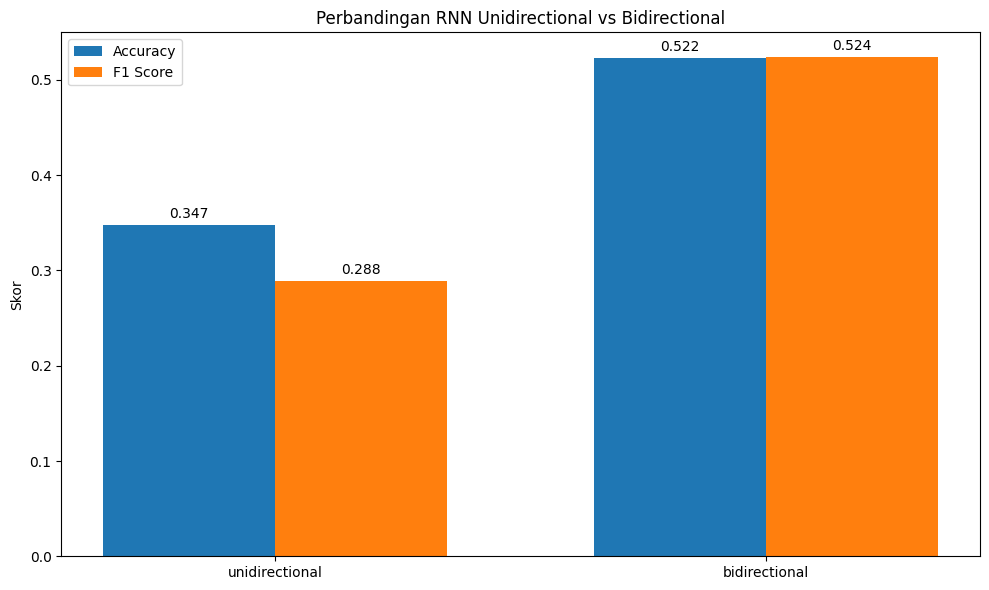

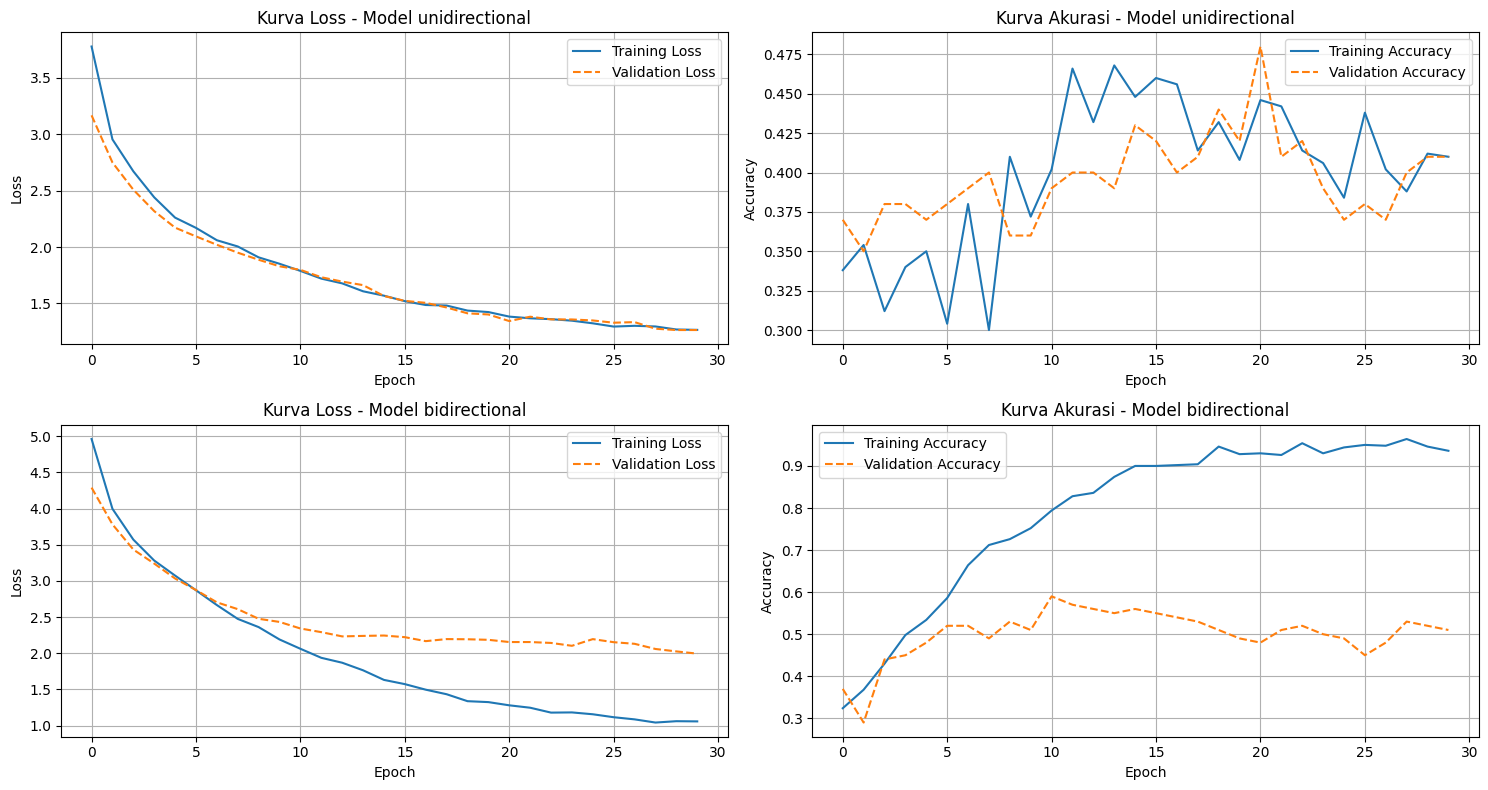

In [18]:
# Tampilkan hasil dalam tabel
print("\nHasil Eksperimen Arah RNN:")
display(bidirectional_results_df)

# Visualisasikan pengaruh arah RNN dengan chart batang
plt.figure(figsize=(10, 6))
directions = bidirectional_results_df['direction'].tolist()
x = np.arange(len(directions))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, bidirectional_results_df['accuracy'], width, label='Accuracy')
rects2 = ax.bar(x + width/2, bidirectional_results_df['f1_score'], width, label='F1 Score')

ax.set_title('Perbandingan RNN Unidirectional vs Bidirectional')
ax.set_ylabel('Skor')
ax.set_xticks(x)
ax.set_xticklabels(directions)
ax.legend()

# Tambahkan nilai di atas bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

# Plot kurva learning untuk perbandingan bidirectional vs unidirectional
plt.figure(figsize=(15, 4 * len(BIDIRECTIONAL_VARIATIONS)))

for i, (direction, history) in enumerate(bidirectional_histories.items()):
    # Plot Loss
    plt.subplot(len(BIDIRECTIONAL_VARIATIONS), 2, 2*i + 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], '--', label='Validation Loss')
    plt.title(f'Kurva Loss - Model {direction}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(len(BIDIRECTIONAL_VARIATIONS), 2, 2*i + 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], '--', label='Validation Accuracy')
    plt.title(f'Kurva Akurasi - Model {direction}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## 3.4. Analisis dan Model Optimal


ANALISIS KOMPREHENSIF SEMUA VARIASI
Rangkuman komprehensif disimpan di experiment_results/variation_summary.csv

Rangkuman Dampak Variasi:


,Variasi,Konfigurasi Terbaik,Akurasi,F1 Score,Dampak Relatif
0,"Layer: Terbaik dari [1, 2, 3]",1 layer,0.6050,0.5937,0.1204
1,"Unit: Terbaik dari [24, 48, 96]",96 unit,0.5925,0.5601,0.2018
2,"Arah: Terbaik dari ['Unidirectional', 'Bidirec...",Bidirectional,0.5225,0.5237,0.2353



Variasi dengan dampak terbesar: Arah RNN
Rentang dampak: 0.2353 perbedaan F1 score


<Figure size 1000x600 with 0 Axes>

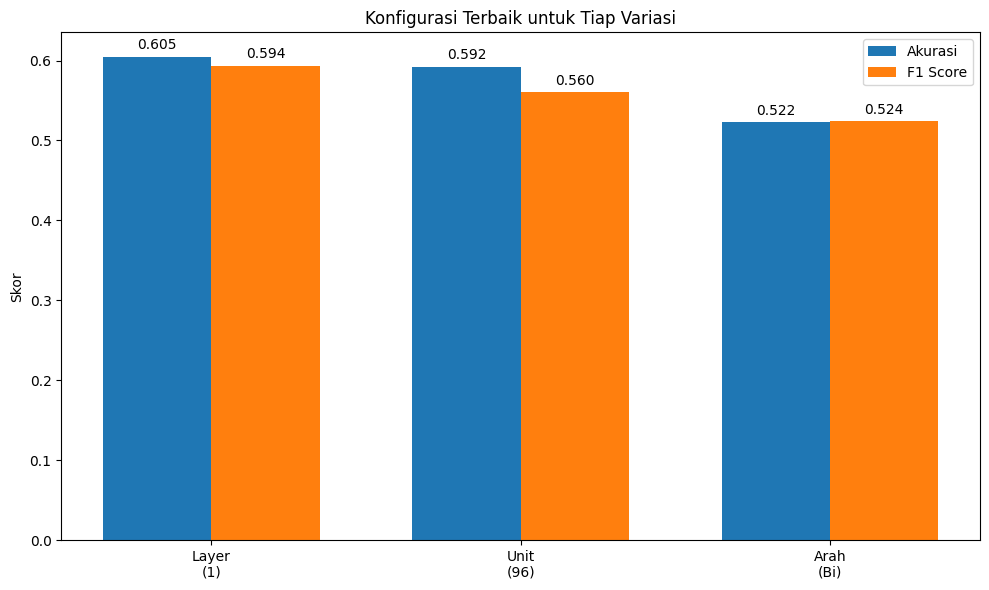


Konfigurasi optimal berdasarkan F1 score:
- Jumlah layer RNN: 1
- Jumlah unit RNN: 96
- Bidirectional: True


In [19]:
def analyze_all_results(layer_results, unit_results, bidirectional_results):
    """Analisis komprehensif dari semua hasil eksperimen"""
    
    print("\n" + "="*50)
    print("ANALISIS KOMPREHENSIF SEMUA VARIASI")
    print("="*50)
    
    # Buat tabel rangkuman
    summary = pd.DataFrame({
        'Variasi': [
            f"Layer: Terbaik dari {RNN_LAYERS_VARIATIONS}",
            f"Unit: Terbaik dari {RNN_UNITS_VARIATIONS}",
            f"Arah: Terbaik dari {['Unidirectional', 'Bidirectional']}"
        ],
        'Konfigurasi Terbaik': [
            f"{layer_results.loc[layer_results['f1_score'].idxmax(), 'num_layers']} layer",
            f"{unit_results.loc[unit_results['f1_score'].idxmax(), 'num_units']} unit",
            f"{'Bidirectional' if bidirectional_results.loc[bidirectional_results['f1_score'].idxmax(), 'is_bidirectional'] else 'Unidirectional'}"
        ],
        'Akurasi': [
            f"{layer_results['accuracy'].max():.4f}",
            f"{unit_results['accuracy'].max():.4f}",
            f"{bidirectional_results['accuracy'].max():.4f}"
        ],
        'F1 Score': [
            f"{layer_results['f1_score'].max():.4f}",
            f"{unit_results['f1_score'].max():.4f}",
            f"{bidirectional_results['f1_score'].max():.4f}"
        ],
        'Dampak Relatif': [
            f"{(layer_results['f1_score'].max() - layer_results['f1_score'].min()):.4f}",
            f"{(unit_results['f1_score'].max() - unit_results['f1_score'].min()):.4f}",
            f"{(bidirectional_results['f1_score'].max() - bidirectional_results['f1_score'].min()):.4f}"
        ]
    })
    
    # Simpan rangkuman ke CSV
    summary_path = f"{RESULTS_DIR}/variation_summary.csv"
    summary.to_csv(summary_path, index=False)
    print(f"Rangkuman komprehensif disimpan di {summary_path}")
    
    # Cetak analisis
    print("\nRangkuman Dampak Variasi:")
    display(summary)
    
    # Tentukan variasi mana yang memberikan dampak terbesar
    impacts = [
        layer_results['f1_score'].max() - layer_results['f1_score'].min(),
        unit_results['f1_score'].max() - unit_results['f1_score'].min(),
        bidirectional_results['f1_score'].max() - bidirectional_results['f1_score'].min()
    ]
    
    variation_names = ['Jumlah Layer', 'Jumlah Unit', 'Arah RNN']
    most_impactful = variation_names[np.argmax(impacts)]
    
    print(f"\nVariasi dengan dampak terbesar: {most_impactful}")
    print(f"Rentang dampak: {max(impacts):.4f} perbedaan F1 score")
    
    # Visualisasikan konfigurasi terbaik untuk setiap variasi
    plt.figure(figsize=(10, 6))
    
    variations = ['Layer', 'Unit', 'Arah']
    best_configs = [
        f"{layer_results.loc[layer_results['f1_score'].idxmax(), 'num_layers']}",
        f"{unit_results.loc[unit_results['f1_score'].idxmax(), 'num_units']}",
        f"{'Bi' if bidirectional_results.loc[bidirectional_results['f1_score'].idxmax(), 'is_bidirectional'] else 'Uni'}"
    ]
    
    best_accuracies = [
        layer_results['accuracy'].max(),
        unit_results['accuracy'].max(),
        bidirectional_results['accuracy'].max()
    ]
    
    best_f1s = [
        layer_results['f1_score'].max(),
        unit_results['f1_score'].max(),
        bidirectional_results['f1_score'].max()
    ]
    
    # Buat label untuk sumbu x yang menunjukkan konfigurasi terbaik
    x_labels = [f"{v}\n({c})" for v, c in zip(variations, best_configs)]
    
    # Plot
    x = np.arange(len(variations))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, best_accuracies, width, label='Akurasi')
    rects2 = ax.bar(x + width/2, best_f1s, width, label='F1 Score')
    
    ax.set_title('Konfigurasi Terbaik untuk Tiap Variasi')
    ax.set_ylabel('Skor')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.legend()
    
    # Tambahkan nilai di atas batang
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    fig.tight_layout()
    plt.show()
    
    # Kembalikan konfigurasi optimal berdasarkan F1 score
    optimal_config = {
        'num_rnn_layers': int(layer_results.loc[layer_results['f1_score'].idxmax(), 'num_layers']),
        'rnn_units': int(unit_results.loc[unit_results['f1_score'].idxmax(), 'num_units']),
        'bidirectional': bool(bidirectional_results.loc[bidirectional_results['f1_score'].idxmax(), 'is_bidirectional'])
    }
    
    print("\nKonfigurasi optimal berdasarkan F1 score:")
    print(f"- Jumlah layer RNN: {optimal_config['num_rnn_layers']}")
    print(f"- Jumlah unit RNN: {optimal_config['rnn_units']}")
    print(f"- Bidirectional: {optimal_config['bidirectional']}")
    
    return optimal_config

# Analisis hasil dari semua eksperimen untuk menemukan konfigurasi optimal
optimal_config = analyze_all_results(layer_results_df, unit_results_df, bidirectional_results_df)


PELATIHAN MODEL DENGAN KONFIGURASI OPTIMAL

Pelatihan model optimal: optimal_rnn_l1_u96_bi
Konfigurasi: {'num_rnn_layers': 1, 'rnn_units': 96, 'bidirectional': True}

--- Training Model: optimal_rnn_l1_u96_bi ---
Config: Layers=1, Units=96, Bidirectional=True, Dropout=0.3, L2=0.01
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 96)         │       272,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 96)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ (None, 192)            │        37,056 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           579 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,891 (1.18 MB)

 Trainable params: 309,891 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3192 - loss: 6.8081
Epoch 1: val_loss improved from inf to 5.62757, saving model to checkpoints/optimal_rnn_l1_u96_bi.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.3202 - loss: 6.7894 - val_accuracy: 0.2600 - val_loss: 5.6276 - learning_rate: 0.0010
Epoch 2/30
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3711 - loss: 5.4447
Epoch 2: val_loss improved from 5.62757 to 4.89058, saving model to checkpoints/optimal_rnn_l1_u96_bi.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3719 - loss: 5.4266 - val_accuracy: 0.4200 - val_loss: 4.8906 - learning_rate: 0.0010
Epoch 3/30
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4305 - loss: 4.7345
Epoch 3: val_loss improved from 4.89058 to 4.43225, saving model to checkpoints/optimal_rnn_l1_u96_bi.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4311 - loss: 4.7184 - val_accuracy: 0.3600 - val_lo

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


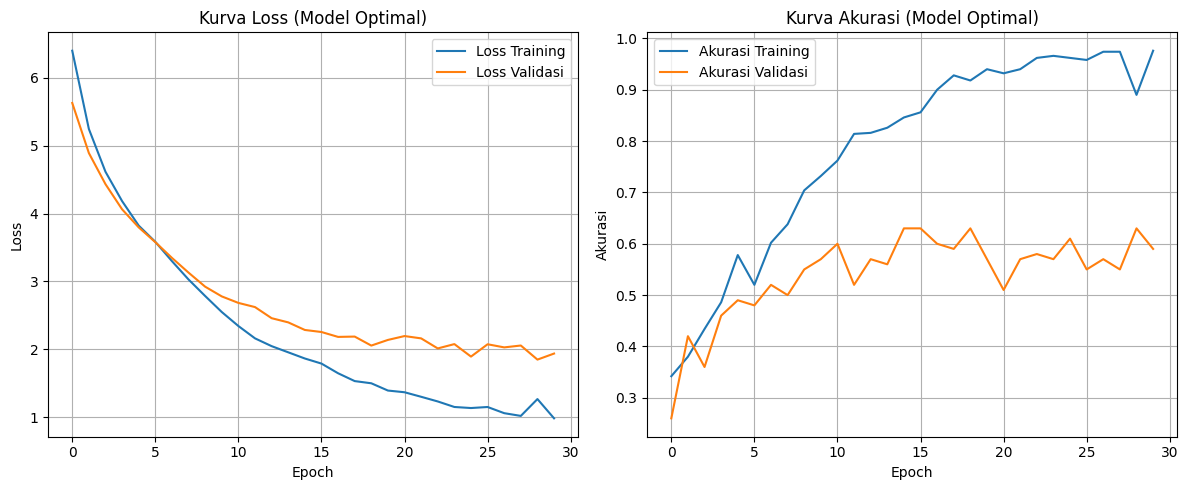

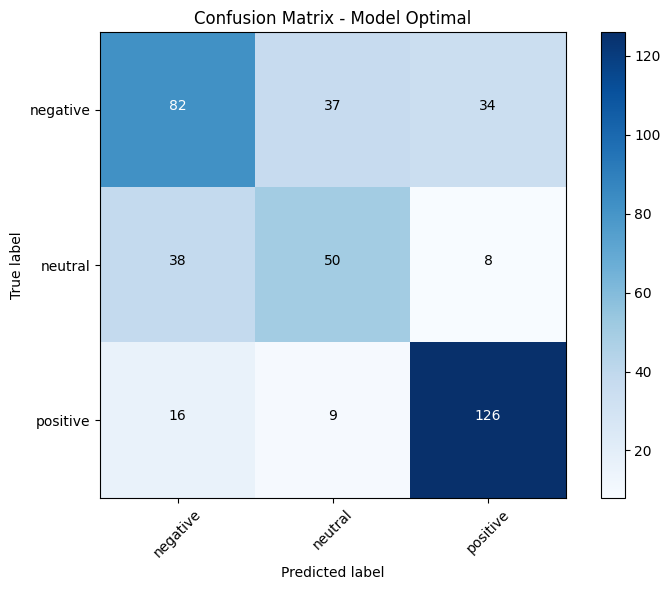

In [20]:
def run_optimal_model(optimal_config):
    """Latih model dengan konfigurasi optimal dari hasil eksperimen"""
    print("\n" + "="*50)
    print("PELATIHAN MODEL DENGAN KONFIGURASI OPTIMAL")
    print("="*50)
    
    # Buat nama model yang menggambarkan konfigurasinya
    model_name = f"optimal_rnn_l{optimal_config['num_rnn_layers']}_u{optimal_config['rnn_units']}_{'bi' if optimal_config['bidirectional'] else 'uni'}"
    
    print(f"\nPelatihan model optimal: {model_name}")
    print(f"Konfigurasi: {optimal_config}")
    
    # Latih dengan konfigurasi optimal
    model, history, preds, labels, vectorizer, metrics = train_and_evaluate_model(
        num_rnn_layers=optimal_config['num_rnn_layers'],
        rnn_units=optimal_config['rnn_units'],
        bidirectional=optimal_config['bidirectional'],
        model_name=model_name
    )
    
    print("\nPerforma Model Optimal:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    # Plot kurva training
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Loss Training")
    plt.plot(history.history["val_loss"], label="Loss Validasi")
    plt.title(f"Kurva Loss (Model Optimal)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Akurasi Training")
    plt.plot(history.history["val_accuracy"], label="Akurasi Validasi")
    plt.title(f"Kurva Akurasi (Model Optimal)")
    plt.xlabel("Epoch")
    plt.ylabel("Akurasi")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Tambahkan confusion matrix untuk model optimal
    y_pred = np.argmax(preds, axis=1)
    cm = confusion_matrix(labels, y_pred)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Model Optimal')
    plt.colorbar()
    class_names = list(label_mapping.keys())
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    
    # Tambahkan nilai di setiap sel
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()
    
    return model, vectorizer, metrics

# Latih model dengan konfigurasi optimal
optimal_model, optimal_vectorizer, optimal_metrics = run_optimal_model(optimal_config)

# 4. Implementasi Forward Propagation dari Awal (From Scratch)
Di sini kita mengimplementasikan forward propagation dari awal menggunakan NumPy dan membandingkannya dengan implementasi Keras.

## 4.1 Pengujian Forward Propagation pada Model Optimal

Menggunakan model optimal dari: models/optimal_rnn_l1_u96_bi_full_model.keras

SIMPLE RNN FROM SCRATCH IMPLEMENTATION
Loaded test data: 400 samples
Loading Keras model from: models/optimal_rnn_l1_u96_bi_full_model.keras
Loading vectorizer from: models/optimal_rnn_l1_u96_bi_vectorizer.keras

Extracting weights from Keras model...
Processing layer: embedding_layer (Type: Embedding)
  Extracted embedding weights, shape: (2836, 96)
Processing layer: embedding_dropout (Type: SpatialDropout1D)
Processing layer: bidirectional_rnn_1 (Type: Bidirectional)
  Extracted Bidirectional SimpleRNN weights for 'bidirectional_rnn_1' with prefix 'bidir_rnn_1_'
    Forward kernel shape: (96, 96)
    Backward kernel shape: (96, 96)
Processing layer: dropout_rnn_1 (Type: Dropout)
Processing layer: output_dense_layer (Type: Dense)
  Extracted output dense layer weights. Kernel: (192, 3), Bias: (3,)
Finished weight extraction. Found 1 RNN layer configurations.
Model loaded and weights extracted successfully.


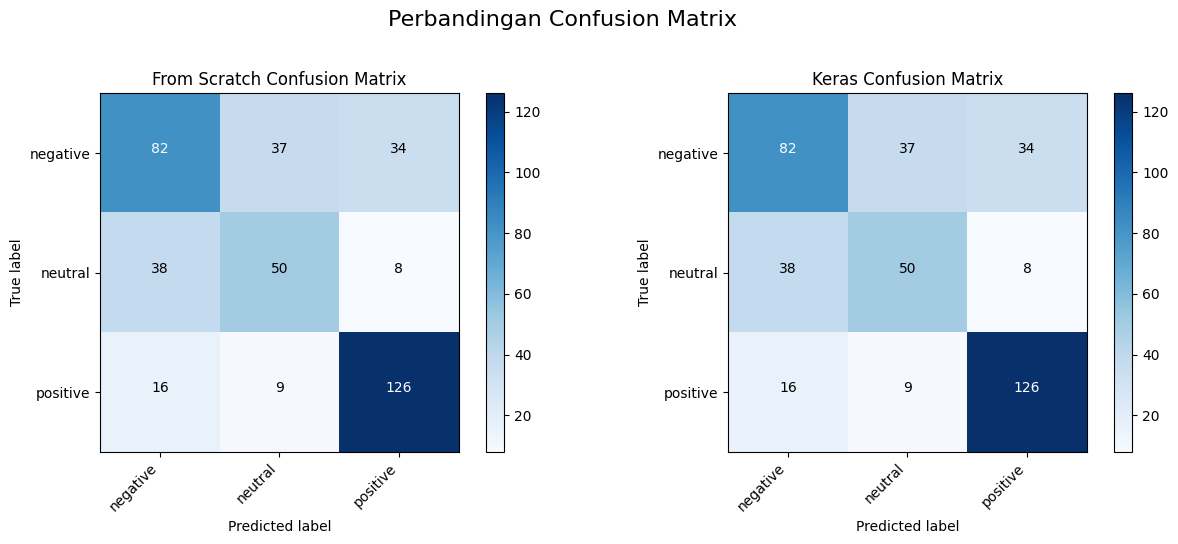

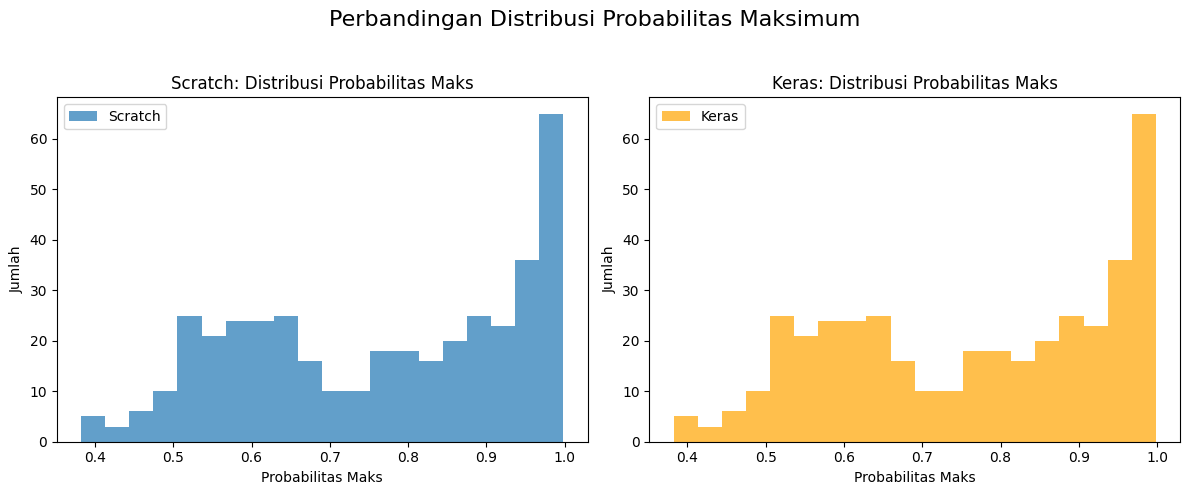

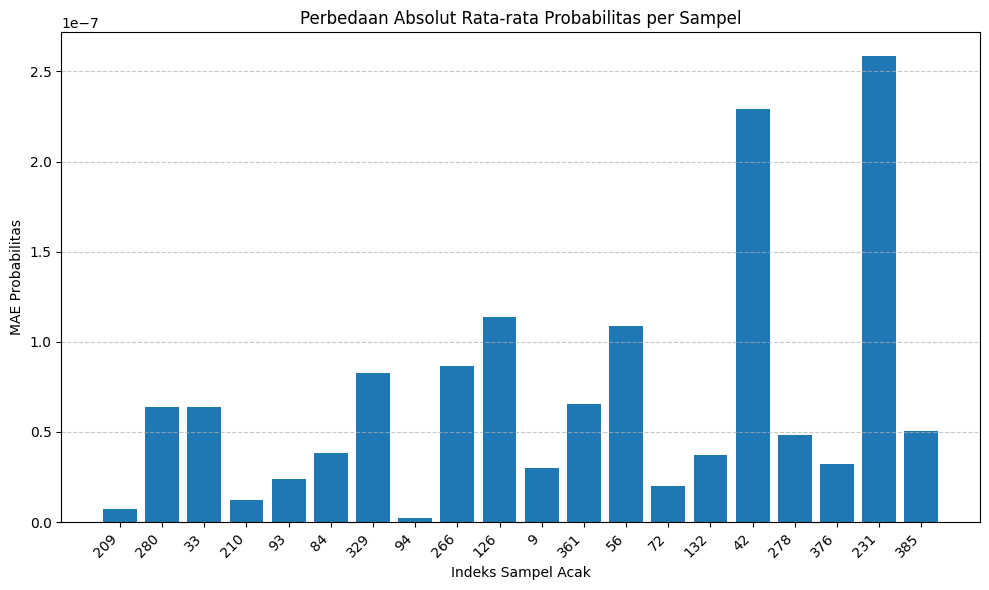

In [21]:
from from_scratch import SimpleRNNFromScratch, run_from_scratch_comparison

# Tentukan path model yang akan digunakan untuk implementasi from scratch
model_path = f"models/optimal_rnn_l{optimal_config['num_rnn_layers']}_u{optimal_config['rnn_units']}_{'bi' if optimal_config['bidirectional'] else 'uni'}_full_model.keras"
vectorizer_path = f"models/optimal_rnn_l{optimal_config['num_rnn_layers']}_u{optimal_config['rnn_units']}_{'bi' if optimal_config['bidirectional'] else 'uni'}_vectorizer.keras"

print(f"Menggunakan model optimal dari: {model_path}")

# Jalankan perbandingan implementasi from scratch dengan Keras
scratch_rnn = run_from_scratch_comparison(model_path, vectorizer_path)

## 4.2. Pengujian Forward Propagation pada Model Lain


UJI FROM SCRATCH: 2 LAYER BIDIRECTIONAL RNN (u48) - MENGGUNAKAN MODEL DARI EKSPERIMEN
Akan menggunakan model Keras dari: models/rnn_layers_2_full_model.keras
Akan menggunakan vectorizer dari: models/rnn_layers_2_vectorizer.keras

SIMPLE RNN FROM SCRATCH IMPLEMENTATION
Loaded test data: 400 samples
Loading Keras model from: models/rnn_layers_2_full_model.keras
Loading vectorizer from: models/rnn_layers_2_vectorizer.keras

Extracting weights from Keras model...
Processing layer: embedding_layer (Type: Embedding)
  Extracted embedding weights, shape: (2836, 96)
Processing layer: embedding_dropout (Type: SpatialDropout1D)
Processing layer: bidirectional_rnn_1 (Type: Bidirectional)
  Extracted Bidirectional SimpleRNN weights for 'bidirectional_rnn_1' with prefix 'bidir_rnn_1_'
    Forward kernel shape: (96, 48)
    Backward kernel shape: (96, 48)
Processing layer: dropout_rnn_1 (Type: Dropout)
Processing layer: bidirectional_rnn_2 (Type: Bidirectional)
  Extracted Bidirectional SimpleRNN w

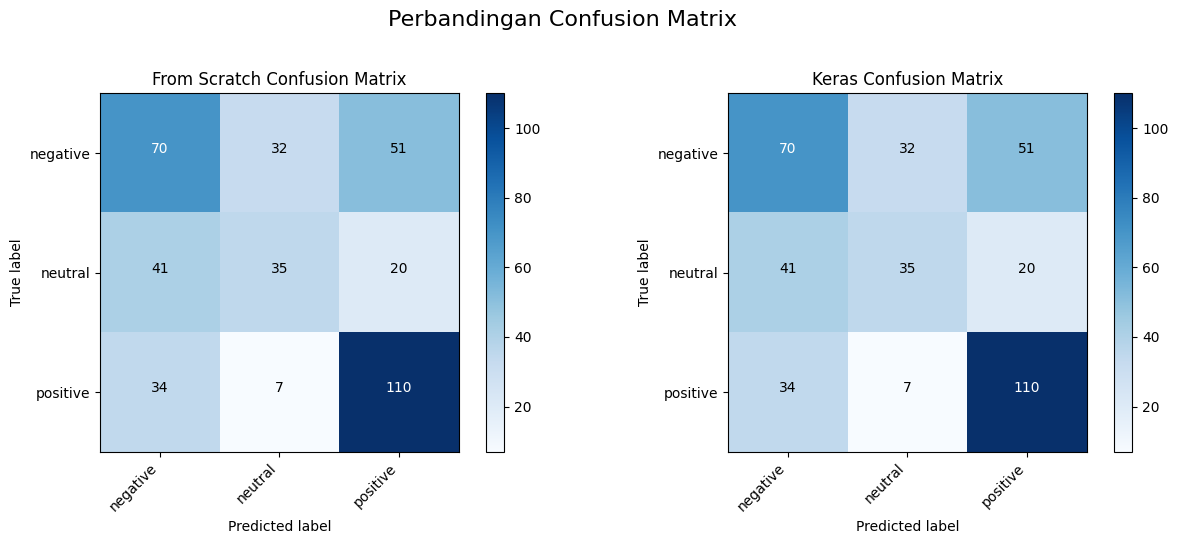

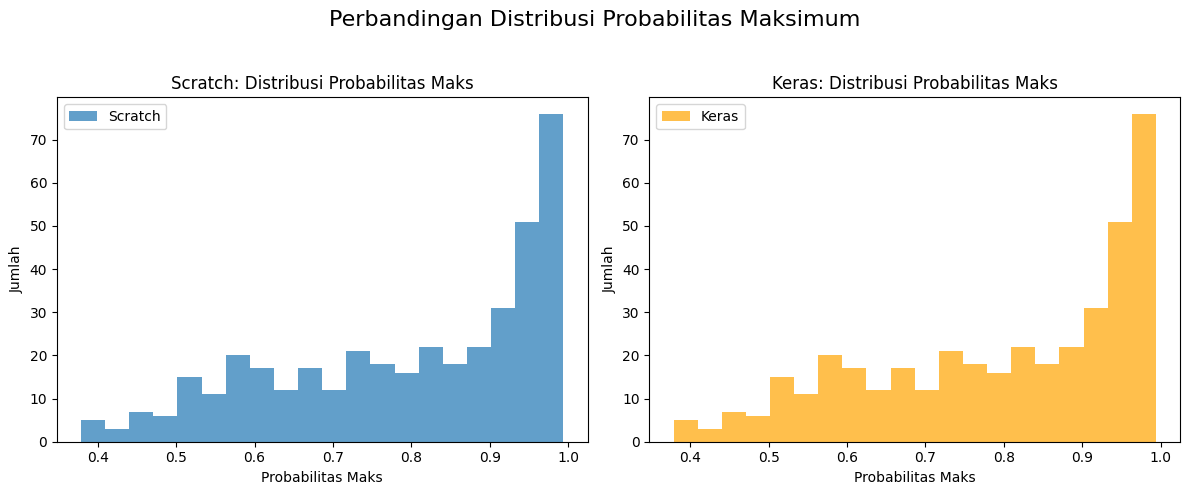

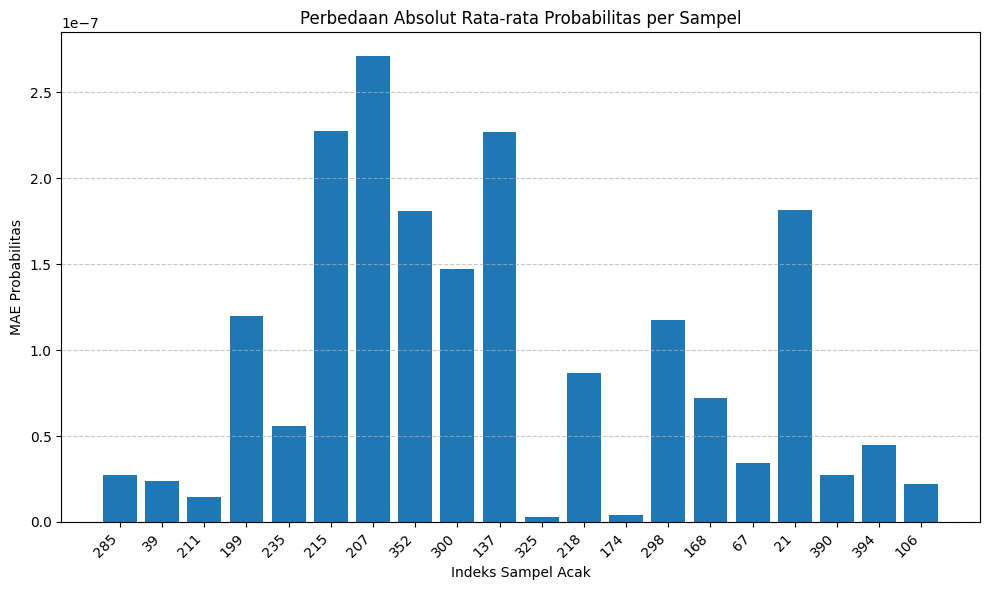

In [22]:
print("\n" + "="*60)
print("UJI FROM SCRATCH: 2 LAYER BIDIRECTIONAL RNN (u48) - MENGGUNAKAN MODEL DARI EKSPERIMEN")
print("="*60)

model_name_l2_bi_exp = "rnn_layers_2" 

keras_model_path_l2_bi_exp = f"models/{model_name_l2_bi_exp}_full_model.keras"
vectorizer_path_l2_bi_exp = f"models/{model_name_l2_bi_exp}_vectorizer.keras"

print(f"Akan menggunakan model Keras dari: {keras_model_path_l2_bi_exp}")
print(f"Akan menggunakan vectorizer dari: {vectorizer_path_l2_bi_exp}")

scratch_rnn_l2_bi_exp = run_from_scratch_comparison(keras_model_path_l2_bi_exp, vectorizer_path_l2_bi_exp)


UJI FROM SCRATCH: 3 LAYER BIDIRECTIONAL RNN (u48) - MENGGUNAKAN MODEL DARI EKSPERIMEN
Akan menggunakan model Keras dari: models/rnn_layers_3_full_model.keras
Akan menggunakan vectorizer dari: models/rnn_layers_3_vectorizer.keras

SIMPLE RNN FROM SCRATCH IMPLEMENTATION
Loaded test data: 400 samples
Loading Keras model from: models/rnn_layers_3_full_model.keras
Loading vectorizer from: models/rnn_layers_3_vectorizer.keras

Extracting weights from Keras model...
Processing layer: embedding_layer (Type: Embedding)
  Extracted embedding weights, shape: (2836, 96)
Processing layer: embedding_dropout (Type: SpatialDropout1D)
Processing layer: bidirectional_rnn_1 (Type: Bidirectional)
  Extracted Bidirectional SimpleRNN weights for 'bidirectional_rnn_1' with prefix 'bidir_rnn_1_'
    Forward kernel shape: (96, 48)
    Backward kernel shape: (96, 48)
Processing layer: dropout_rnn_1 (Type: Dropout)
Processing layer: bidirectional_rnn_2 (Type: Bidirectional)
  Extracted Bidirectional SimpleRNN w

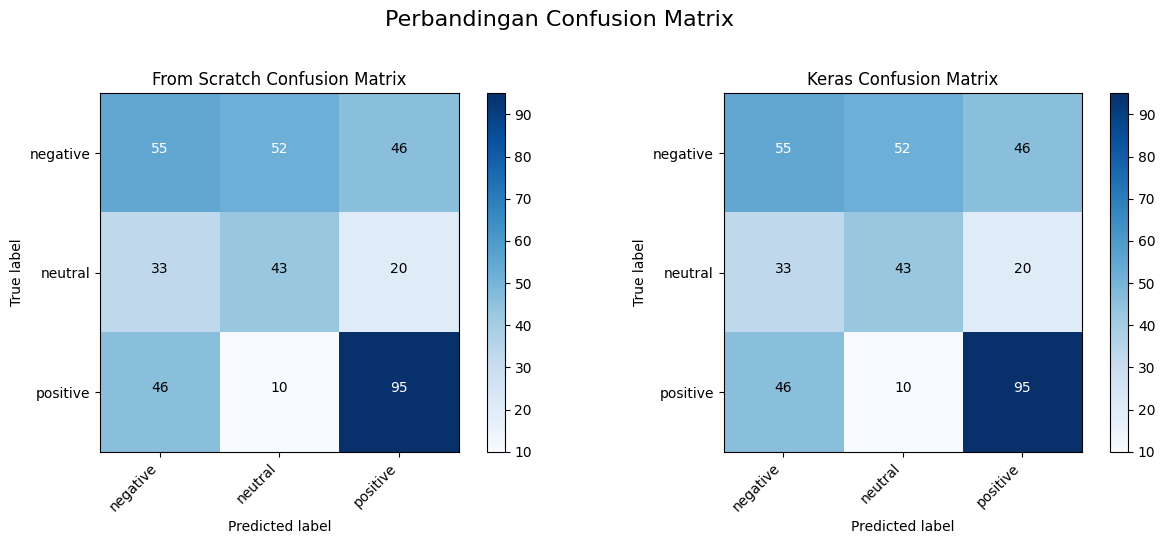

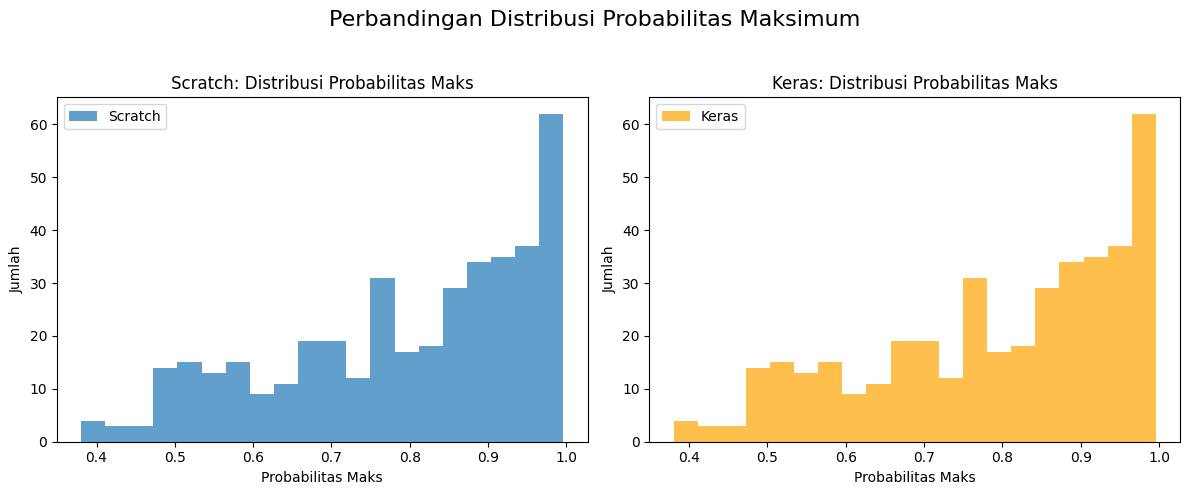

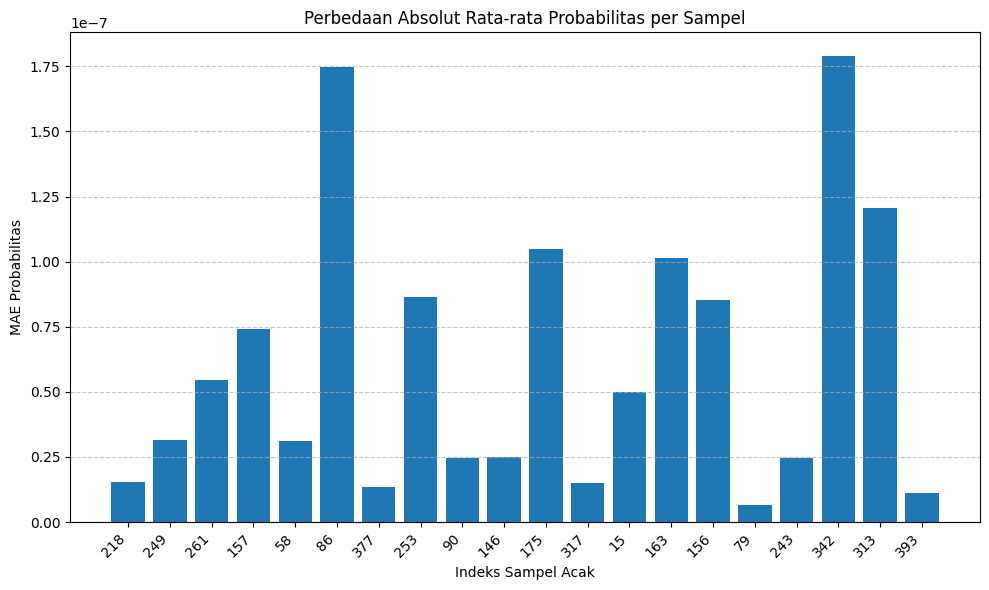

In [23]:
print("\n" + "="*60)
print("UJI FROM SCRATCH: 3 LAYER BIDIRECTIONAL RNN (u48) - MENGGUNAKAN MODEL DARI EKSPERIMEN")
print("="*60)

model_name_l3_bi_exp = "rnn_layers_3" 

keras_model_path_l3_bi_exp = f"models/{model_name_l3_bi_exp}_full_model.keras"
vectorizer_path_l3_bi_exp = f"models/{model_name_l3_bi_exp}_vectorizer.keras"

print(f"Akan menggunakan model Keras dari: {keras_model_path_l3_bi_exp}")
print(f"Akan menggunakan vectorizer dari: {vectorizer_path_l3_bi_exp}")

scratch_rnn_l3_bi_exp = run_from_scratch_comparison(keras_model_path_l3_bi_exp, vectorizer_path_l3_bi_exp)


PERSIAPAN UJI FROM SCRATCH: 1 LAYER UNIDIRECTIONAL RNN (u48) - MENGGUNAKAN MODEL DARI EKSPERIMEN
Akan menggunakan model Keras dari: models/rnn_unidirectional_full_model.keras
Akan menggunakan vectorizer dari: models/rnn_unidirectional_vectorizer.keras

SIMPLE RNN FROM SCRATCH IMPLEMENTATION
Loaded test data: 400 samples
Loading Keras model from: models/rnn_unidirectional_full_model.keras
Loading vectorizer from: models/rnn_unidirectional_vectorizer.keras

Extracting weights from Keras model...
Processing layer: embedding_layer (Type: Embedding)
  Extracted embedding weights, shape: (2836, 96)
Processing layer: embedding_dropout (Type: SpatialDropout1D)
Processing layer: simplernn_layer_1 (Type: SimpleRNN)
  Extracted Unidirectional SimpleRNN weights for 'simplernn_layer_1' with prefix 'unidir_rnn_1_'
    Kernel shape: (96, 48)
Processing layer: dropout_rnn_1 (Type: Dropout)
Processing layer: output_dense_layer (Type: Dense)
  Extracted output dense layer weights. Kernel: (48, 3), Bias

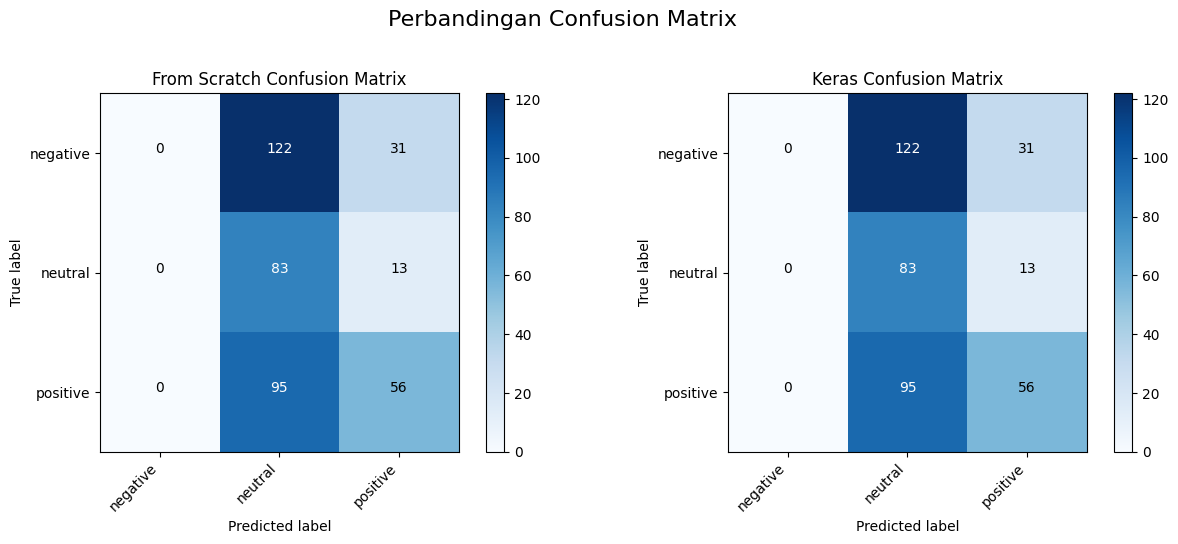

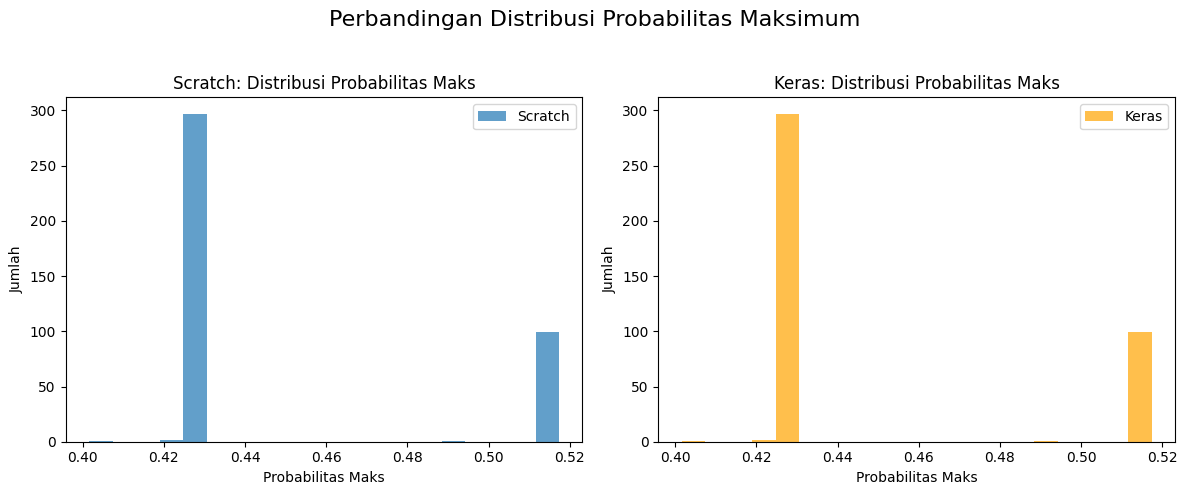

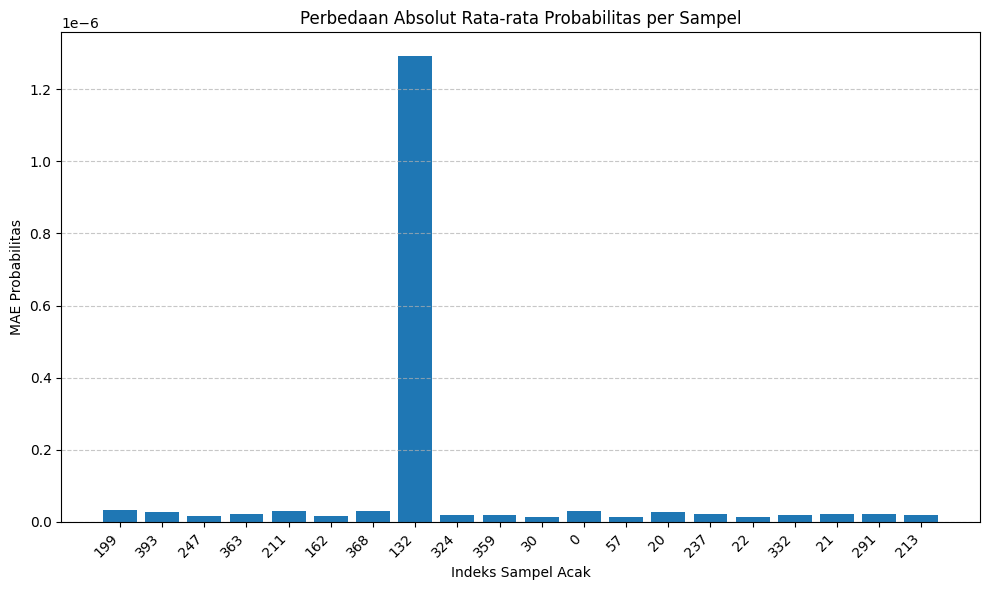

In [24]:
print("\n" + "="*60)
print("PERSIAPAN UJI FROM SCRATCH: 1 LAYER UNIDIRECTIONAL RNN (u48) - MENGGUNAKAN MODEL DARI EKSPERIMEN")
print("="*60)

model_name_l1_uni_exp = "rnn_unidirectional" 

keras_model_path_l1_uni_exp = f"models/{model_name_l1_uni_exp}_full_model.keras"
vectorizer_path_l1_uni_exp = f"models/{model_name_l1_uni_exp}_vectorizer.keras"

print(f"Akan menggunakan model Keras dari: {keras_model_path_l1_uni_exp}")
print(f"Akan menggunakan vectorizer dari: {vectorizer_path_l1_uni_exp}")

scratch_rnn_l1_uni_exp = run_from_scratch_comparison(keras_model_path_l1_uni_exp, vectorizer_path_l1_uni_exp)